In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxonium_v2 import FluxoniumPocket
from qiskit_metal.qlibrary.qubits.fluxoniumEPR import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

from qiskit_metal.analyses.sweep_and_optimize.sweeping import Sweeping

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis 

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'  # our substrate is Silicon
# cpw_width and cpw_gap is defined from the beginnning if you need you can 
# change it later. But with this way one can be sure all the lines are having same width and gap.
design.variables['cpw_width'] = '15 um'  
design.variables['cpw_gap'] = '8.733 um'  
design._chips['main']['size']['size_x'] = '9mm'  # Our device size is 9*9mm
design._chips['main']['size']['size_y'] = '9mm'

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# run the GUI 
gui = MetalGUI(design)


In [3]:
from qiskit_metal.qlibrary.terminations.ebeam_marker_v2 import Markers
from qiskit_metal.qlibrary.terminations.ebeam_frame import Frame

## Markers for ebeam
options = dict(pos_x='3.25mm', pos_y='4.25mm')
mrk1 = Markers(design, 'marker1', options = options)

options = dict(pos_x='-3.25mm', pos_y='4.25mm')
mrk2 = Markers(design, 'marker2', options = options)

options = dict(pos_x='-3.25mm', pos_y='-4.25mm')
mrk3 = Markers(design, 'marker3', options = options)

options = dict(pos_x='3.25mm', pos_y='-4.25mm')
mrk4 = Markers(design, 'marker4', options = options)

options = dict(chip='main', f_gap='140um',)
frame = Frame(design, 'frame', options = options)

gui.rebuild()

In [4]:
#Setup the launchpad1 location and orientation

## Read In launch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-3.99mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadIn', options = launch_options)


# Read Out launch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='3.99mm', orientation='180',
                      lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um',
                    )
lp = LaunchpadWirebond(design, 'LPReadOut', options = launch_options)


Transmission_Line = {'pin_inputs':
           {'start_pin': {'component': 'LPReadIn', 'pin': 'tie'},
             'end_pin': {'component': 'LPReadOut', 'pin': 'tie'}},
            'lead': {'start_straight': '3970um', 'end_straight': '3970um',
                    # 'start_jogged_extension': jogs_in,
                    # 'anchors': anchors1,
                    }, 
                    'total_length': '8mm', 'fillet': "90um"
            }

TransLine = RoutePathfinder(design, 'TL', Transmission_Line)


gui.rebuild()

In [5]:
from qiskit_metal.qlibrary.qubits.fluxonium_v2 import FluxoniumPocket

gds_cell_name_jj = 'junction_0'

## Every qubit options are slightly different than each other, that's why I seperated them. 
# Q1 details
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False,
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor ,
               inductor_orientation='-1', jj_orientation='-1',
                    
    flux_bias_line_options=Dict(make_fbl = True),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True)
              )

q1 = FluxoniumPocket(design,'Q1', options = dict(pos_x = '-2.2mm', pos_y = '-0.475mm',orientation =270,
        **options))

# Q2 details
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1', 
               
    flux_bias_line_options=Dict(make_fbl = True),
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q2 = FluxoniumPocket(design,'Q2', options = dict(pos_x = '-2.2mm', pos_y = '0.475mm',orientation =90,
             **options))

# Q4 details
gds_cell_name_inductor = 'jj_array_v1_0'
options = dict(chip='main', nanowire = False,               
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', 
                    
    flux_bias_line_options=Dict(make_fbl = True),
    charge_line_options=Dict(loc_H = -1, make_cl = True), 
    readout_line_options=Dict(loc_H = +1, make_rol = True) 
              )

q4 = FluxoniumPocket(design,'Q4', options = dict(pos_x = '2.2mm', pos_y = '0.475mm',orientation =90,
        **options))

               
# Q5 details    
gds_cell_name_inductor = 'jj_array_v2_0'
options = dict(chip='main', nanowire = False, 
            gds_cell_name=gds_cell_name_jj,
            gds_cell_inductor=gds_cell_name_inductor,
               inductor_orientation='-1', jj_orientation='-1',
                           
    flux_bias_line_options=Dict(make_fbl = True), 
    charge_line_options=Dict(loc_H = +1, make_cl = True),
    readout_line_options=Dict(loc_H = -1, make_rol = True) 
              )

q5 = FluxoniumPocket(design,'Q5', options = dict(pos_x = '2.2mm', pos_y = '-0.475mm',orientation =270,
             **options))

gui.rebuild()
gui.autoscale()

In [18]:
## The test structures: these are for room temp probing!
# Q JJ1 Trial details
gds_cell_name_jj = 'junction_0'
gds_cell_name_inductor = 'jj_array_v1_0'

options = dict(chip='main',  nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.0mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ1 = FluxoniumPocket(design,'QJJ1', options = dict(
        **options))

# Q JJ2 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.2mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,   
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ2 = FluxoniumPocket(design,'QJJ2', options = dict(
        **options))

# Q JJ3 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '-1.0mm', pos_y = '3.4mm',
               pocket_width= '600um',
        gds_cell_name=gds_cell_name_jj,  
               
    flux_bias_line_options=Dict(make_fbl = False), 
               
    charge_line_options=Dict(loc_H = -1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = 1, make_rol = False,
              ) )
               
qJJ3 = FluxoniumPocket(design,'QJJ3', options = dict(
        **options))


# Q Array1 details
options = dict(chip='main', nanowire = False, 
            orientation =90, pos_x = '1.0mm', pos_y = '3.0mm',
            gds_cell_inductor=gds_cell_name_inductor , pocket_width= '600um',
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                        ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
               ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr1 = FluxoniumPocket(design,'QArr1', options = dict(
             **options))


# Q Array2 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '3.2mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor ,   
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                               ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr2 = FluxoniumPocket(design,'QArr2', options = dict(
        **options))

# Q Array3 Trial details
options = dict(chip='main', nanowire = False,
        orientation =90, pos_x = '1.0mm', pos_y = '3.4mm',
               pocket_width= '600um',
        gds_cell_inductor=gds_cell_name_inductor , 
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = False,
                      ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = False,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = False, 
              ) )
               
qArr3 = FluxoniumPocket(design,'QArr3', options = dict(
        **options))
gui.rebuild() 

In [31]:
from qiskit_metal.qlibrary.qubits.tmon_c import Tmon_c
gds_cell_name_jj = 'junction_sq_1'

# Qc-3 details
options = dict(jj_gap ='30um', pad_arm_length='825um', pad_head_length='400um',
        pad_arm_width='15um', palm_radius='63um',
       pad_gap='30um', circle_gap='15um', x_gap='10.5um',
                     gds_cell_name=gds_cell_name_jj,      
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
               
# Create a new Transmon Cross object with name 'Q3'
q3 = Tmon_c(design, 'Q3', options=dict(pos_x = '-2.36mm', pos_y = '0mm', 
                                       orientation='90',
                                             **options))
# Qc-6 details
gds_cell_name_jj = 'junction_sq_0'
options = dict(jj_gap ='30um', pad_arm_length='825um', pad_head_length='400um',
        pad_arm_width='15um', palm_radius='63um',
       pad_gap='30um', circle_gap='15um', x_gap='10.5um',
                     gds_cell_name=gds_cell_name_jj,       
    flux_bias_line_options=Dict(make_fbl = True, fbl_sep='30um', 
                            fbl_length = '100um'), 
                                 )
q6 = Tmon_c(design, 'Q6', options=dict(pos_x = '2.36mm', pos_y = '0mm', 
                                       orientation='270',
                                             **options))

gui.rebuild()  # rebuild the design and plot
#gui.autoscale() #resize GUI to see QComponent

In [10]:
# Lambda/2 resonators - Resonator1
from collections import OrderedDict
jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', 
                 pos_x='-38.0um', pos_y='-0.3mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        total_length='9.81mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1700um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='Q1', pin='readout_line')), ))

# Lambda/2 resonators - Resonator2
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
jogs_in[1] = ["L", '200um']

otg2 = OpenToGround(design, 'otg2s', options=dict(chip='main', 
                 pos_x='-38.0um', pos_y='0.5mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity2',  Dict(meander=Dict(spacing='200um'),
        total_length='8.95mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1480um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg2s', pin='open'),
            end_pin=Dict(component='Q2', pin='readout_line')), ))

# Lambda/2 resonators - Resonator4

jogs_in = OrderedDict()
jogs_in[0] = ["R", '200um']
jogs_in[1] = ["R", '200um']

otg4 = OpenToGround(design, 'otg4s', options=dict(chip='main', pos_x='38.0um',  pos_y='0.5mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity4',  Dict(meander=Dict(spacing='200um'),
        total_length='8.20mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1320um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg4s', pin='open'),
            end_pin=Dict(component='Q4', pin='readout_line')), ))

# Lambda/2 resonators - Resonator5
jogs_in = OrderedDict()
jogs_in[0] = ["L", '200um']
jogs_in[1] = ["L", '200um']

otg5= OpenToGround(design, 'otg5s', options=dict(chip='main', 
                 pos_x='38.0um', pos_y='-0.5mm', orientation='90'))
rt_meander = RouteMeander(design, 'cavity5',  Dict(meander=Dict(spacing='200um'),
        total_length='7.58mm',
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='1190um', 
                    start_jogged_extension= jogs_in),
        pin_inputs=Dict(
            start_pin=Dict(component='otg5s', pin='open'),
            end_pin=Dict(component='Q5', pin='readout_line')), ))

gui.rebuild()

In [11]:
# Q1 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-1.34mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPCL1', options = launch_options) #change line

launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='-2.68mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB1', options = launch_options) #flux line

# Q2 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='1.34mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPCL2', options = launch_options) #charge line

launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='2.68mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB2', options = launch_options) #flux line

# Q4 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='1.348mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPCL4', options = launch_options) #change line

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='2.68mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB4', options = launch_options) #flux line

# Q5 flux-bias and charge line's lauch pad
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-1.34mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPCL5', options = launch_options) #change line

launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-2.68mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB5', options = launch_options) #flux line

# Q3 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='-4.0mm', pos_y='0.0575mm', orientation='0',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB3', options = launch_options) #flux line

# Q6 flux-bias line's lauch pad, the tmon
launch_options = dict(chip='main', pos_x='4.0mm', pos_y='-0.0575mm', orientation='180',
        lead_length='30um', pad_width='200um',
        pad_height='200um', pad_gap='112um')
lp = LaunchpadWirebond(design, 'LPFB6', options = launch_options) #flux line

gui.rebuild()

In [12]:
#Charge Line for Q1
XYCharge_LineQ1 = RoutePathfinder(design, 'XY_Gate1',
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='850um',
                      ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q1',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL1',
                                            pin='tie')
                                            )))
# Flux Bias Line for Q1
ZFluxBias_LineQ1 = RoutePathfinder(design, 'Z_Gate1', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um', 
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q1', 
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB1', pin='tie')
                                   )))

# Charge Lıne for Q2
XYCharge_LineQ2 = RoutePathfinder(design, 'XY_Gate2', options = dict(chip='main',
                        fillet='80um',
                lead=dict(start_straight='150um', end_straight='850um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='charge_line'),
                                                end_pin=Dict(
                                                    component='LPCL2',
                                                    pin='tie')
                                            )))

# Flux Bias Line for Q2
ZFluxBias_LineQ2 = RoutePathfinder(design, 'Z_Gate2', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='250um', end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q2',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB2',
                                                    pin='tie')
                                            )))

#Charge Line for Q4
XYCharge_LineQ4 = RoutePathfinder(design, 'XY_Gate4', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='600um'),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q4',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL4',
                                            pin='tie')
                                            )))

# Flux Bias Line for Q4
ZFluxBias_LineQ4 = RoutePathfinder(design, 'Z_Gate4', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um', 
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q4', 
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB4', pin='tie')
                                   )))

#Charge Line for Q5
XYCharge_LineQ5 = RoutePathfinder(design, 'XY_Gate5', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='150um', end_straight='600um', 
                      ),
                         pin_inputs=Dict( start_pin=Dict(
                                          component='Q5',
                                               pin='charge_line'),
                                                end_pin=Dict(
                                            component='LPCL5',
                                            pin='tie')
                                            )))

# Flux Bias Line for Q5
ZFluxBias_LineQ5 = RoutePathfinder(design, 'Z_Gate5', 
        options = dict(chip='main', fillet='99um',
            lead=dict(start_straight='200um', 
        end_straight='400um', ),
        pin_inputs=Dict(start_pin=Dict(component='Q5', 
              pin='flux_bias_line'),
          end_pin=Dict(component='LPFB5', pin='tie')
                                   )))

# Flux Bias Line for Q3
ZFluxBias_LineQ3 = RoutePathfinder(design, 'Z_Gate3', options = dict(chip='main',
             fillet='20um',
          lead=dict(start_straight='150um', end_straight='80um'),
        pin_inputs=Dict(start_pin=Dict(component='Q3',
                 pin='flux_bias_line'),
                end_pin=Dict(component='LPFB3',pin='tie')
                                            )))

# Flux Bias Line for Q6
ZFluxBias_LineQ6 = RoutePathfinder(design, 'Z_Gate6', options = dict(chip='main',
             fillet='99um',
          lead=dict(start_straight='250um', end_straight='250um'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='Q6',
                                                    pin='flux_bias_line'),
                                                end_pin=Dict(
                                                    component='LPFB6',
                                                    pin='tie')
                                            )))

gui.rebuild()

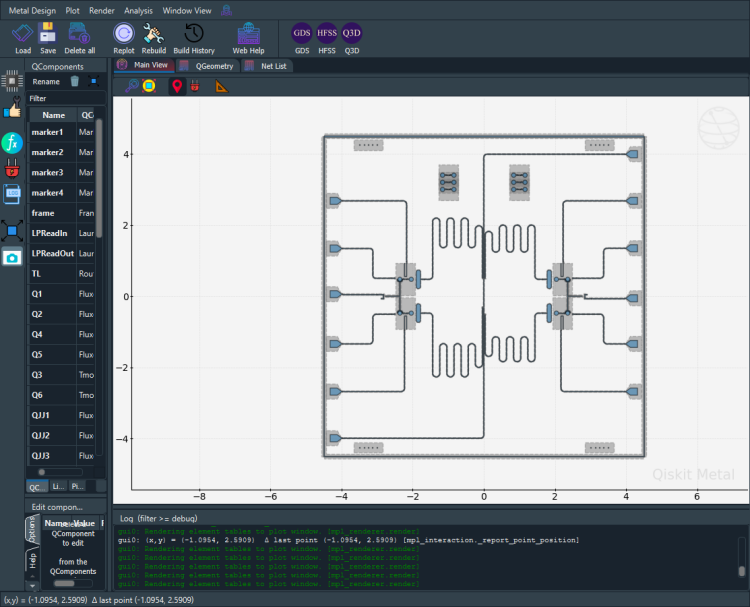

In [13]:
#Save screenshot as a .png formatted file.
gui.screenshot()

## Starting Simulations

### Starts with Maxwell Capacitance Matrix

In [34]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [40]:
# for second method. dont run this
# example: update single setting
c1.sim.setup.max_passes = 15
# example: update multiple settings
c1.sim.setup_update(solution_order = 'Medium', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'Medium',
 'solver_type': 'Iterative',
 'run': {'name': None,
  'components': ['Q5'],
  'open_terminations': [('Q5', 'charge_line'),
   ('Q5', 'flux_bias_line'),
   ('Q5', 'fake_flux_bias_line'),
   ('Q5', 'readout_line')],
  'box_plus_buffer': True}}

In [41]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [42]:
# Qubit 5 has the default settings in terms of readout pads and charge line places.
Q_nr = '5'
c1.sim.run(components=['Q'+Q_nr], open_terminations=[('Q'+Q_nr, 'charge_line'), ('Q'+Q_nr, 'flux_bias_line'), ('Q'+Q_nr, 'fake_flux_bias_line'),('Q'+Q_nr, 'readout_line')])
c1.sim.capacitance_matrix

INFO 02:37PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:37PM [analyze]: Analyzing setup Setup
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp824yksw6.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpb19gyurb.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpp7o9f0fi.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:40PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp039ab_pf.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,charge_line_Q5,flux_bias_line_Q5,ground_main_plane,pad_bot_Q5,pad_top_Q5,readout_padNline_Q5
charge_line_Q5,22.19177,-0.13863,-21.21136,-0.06520,-0.57906,-0.04547
flux_bias_line_Q5,-0.13863,59.11046,-45.23507,-4.74370,-4.77335,-2.20077
ground_main_plane,-21.21136,-45.23507,348.96242,-21.76811,-25.58868,-166.47575
pad_bot_Q5,-0.06520,-4.74370,-21.76811,36.90938,-3.46413,-5.45013
pad_top_Q5,-0.57906,-4.77335,-25.58868,-3.46413,36.88631,-1.05374
readout_padNline_Q5,-0.04547,-2.20077,-166.47575,-5.45013,-1.05374,177.59942


In [43]:
# capacitance with pocket-height=650um

Cpad_top = 25.588
Cpad_bot = 21.768
Creadout_bot = 5.4501
Ccharge_top = 0.5790
Cfluxpad_top = 4.7733
Cfluxpad_bot = 4.74370

C_pads = 3.4641

C_top = Cpad_top + Ccharge_top + Cfluxpad_top
C_bot = Cpad_bot + Creadout_bot + Cfluxpad_bot

Csigma = C_pads + C_top*C_bot/(C_top+C_bot)
print('Total Capacitance:', Csigma, 'fF')

Total Capacitance: 19.185477832218638 fF


In [44]:
e = 1.60217663e-19
hbar = 1.05457182e-34

Ec = e**2/(2*Csigma*1e-15)
Charging_energy = 1e-6*Ec/(2*np.pi*hbar)
print('Charging Energy:', Charging_energy, 'MHz')

Charging Energy: 1009.629749860886 MHz


## Maxwell Capacitance Matrix to calculate Kappa between Res to TL

In [11]:
from qiskit_metal.analyses.quantization import LOManalysis

c2 = LOManalysis(design, "q3d")
c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [12]:
# for second method. dont run this
# example: update single setting
c2.sim.setup.max_passes = 15
# example: update multiple settings
c2.sim.setup_update(solution_order = 'High', auto_increase_solution_order = 'True')

c2.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'True',
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [78]:
## Lambda/2 resonators- Dressed frequency 
pi=np.pi
Z_0=50.0 # ohm
Z_r=50.0 #ohm
f_1=5.484949e9 #Hz
f_2=5.955879e9 #Hz
f_4=6.472919e9 #Hz
f_5=6.923041e9 #Hz

C_1=29.87954e-15 #F
omega_1=2*pi*f_1
Q_c1=pi/(Z_0*Z_r*(C_1*omega_1)**2)
Kappa_1=(f_1/Q_c1)*1e-6

C_2=26.01928e-15 #F
omega_2=2*pi*f_2
Q_c2=pi/(Z_0*Z_r*(C_2*omega_2)**2)
Kappa_2=(f_2/Q_c2)*1e-6

C_4=22.99466e-15 #F
omega_4=2*pi*f_4
Q_c4=pi/(Z_0*Z_r*(C_4*omega_4)**2)
Kappa_4=(f_4/Q_c4)*1e-6

C_5=20.70734e-15 #F
omega_5=2*pi*f_5
Q_c5=pi/(Z_0*Z_r*(C_5*omega_5)**2)
Kappa_5=(f_5/Q_c5)*1e-6

print('Q_c of the R1 is', Q_c1, '')
print('Q_c of the R2 is', Q_c2, '')
print('Q_c of the R4 is', Q_c4, '')
print('Q_c of the R5 is', Q_c5, '')

print('Kappa of the R1 is', Kappa_1, 'MHz')
print('Kappa of the R2 is', Kappa_2, 'MHz')
print('Kappa of the R4 is', Kappa_4, 'MHz')
print('Kappa of the R5 is', Kappa_5, 'MHz')

Q_c of the R1 is 1185.105804925255 
Q_c of the R2 is 1325.4637229940672 
Q_c of the R4 is 1436.7982736874314 
Q_c of the R5 is 1548.844048599349 
Kappa of the R1 is 4.628235704529299 MHz
Kappa of the R2 is 4.4934304098088536 MHz
Kappa of the R4 is 4.505099371665971 MHz
Kappa of the R5 is 4.469811538650806 MHz


In [79]:
c2.sim.run(components=['TL', 'cavity4'], open_terminations=[('cavity4', 'end'), ('cavity4', 'start'), ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 02:14PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 02:14PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 02:14PM [analyze]: Analyzing setup Setup
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmps_fj0aip.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpmh_u1t6h.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp8q9ao4e_.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 02:25PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpqxg2go4z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity4,trace_TL
g_wb,4258.06676,-1314.33012,-2571.26277
trace_cavity4,-1314.33012,1338.26133,-22.99466
trace_TL,-2571.26277,-22.99466,2596.59543


In [22]:
c2.sim.run(components=['TL','cavity1', 'cavity2'], open_terminations=[('cavity1', 'end'), ('cavity1', 'start'), ('cavity2', 'end'), ('cavity2', 'start'), ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 09:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 09:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 09:56PM [analyze]: Analyzing setup Setup
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpl6o5697n.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp_t61a_4q.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpyl66zixt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:18PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpa41p_2rd.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity1,trace_cavity2,trace_TL
g_wb,6000.63239,-1596.00636,-1456.14694,-2579.18037
trace_cavity1,-1596.00636,1624.78419,-0.01738,-27.77818
trace_cavity2,-1456.14694,-0.01738,1483.13080,-26.01928
trace_TL,-2579.18037,-27.77818,-26.01928,2635.47641


10:18PM 43s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [23]:
## TODO: remove the wire bonds first
c2.sim.run(components=['TL','cavity4', 'cavity5'], open_terminations=[('cavity4', 'end'), ('cavity4', 'start'),('cavity5', 'end'), ('cavity5', 'start'), ('TL', 'end'), ('TL', 'start')])
c2.sim.capacitance_matrix

INFO 10:18PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 10:18PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 10:18PM [analyze]: Analyzing setup Setup
INFO 10:34PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmpj8amiapr.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:34PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp46axi4bc.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 10:34PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp3uz_8wz7.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 10:34PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppData\Local\Temp\tmp07vp1_2i.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSi

,g_wb,trace_cavity4,trace_cavity5,trace_TL
g_wb,5487.90505,-1324.86326,-1226.97568,-2566.34442
trace_cavity4,-1324.86326,1349.97362,-0.02241,-24.17964
trace_cavity5,-1226.97568,-0.02241,1248.50489,-20.70734
trace_TL,-2566.34442,-24.17964,-20.70734,2613.73703


## EPR analysis with ANSYS-HFSS

In [49]:
hfss.open_ansys()

In [50]:
hfss.connect_ansys()

INFO 07:38PM [connect_project]: Connecting to Ansys Desktop API...
INFO 07:38PM [load_ansys_project]: 	Opened Ansys App
INFO 07:38PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 07:38PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project49
INFO 07:38PM [connect_design]: No active design found (or error getting active design).
INFO 07:38PM [connect]: 	 Connected to project "Project49". No design detected


In [51]:
hfss.activate_eigenmode_design("cavity1")

07:38PM 33s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
07:38PM 33s WARNING [activate_ansys_design]: The design_name=cavity1 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 07:38PM [connect_design]: 	Opened active design
	Design:    cavity1 [Solution type: Eigenmode]
WARNING 07:38PM [connect_setup]: 	No design setup detected.
WARNING 07:38PM [connect_setup]: 	Creating eigenmode default setup.
INFO 07:38PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [52]:
hfss.render_design(['cavity1'], [('cavity1', 'end'), ('cavity1', 'start')])

In [53]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 07:38PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


07:42PM 08s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


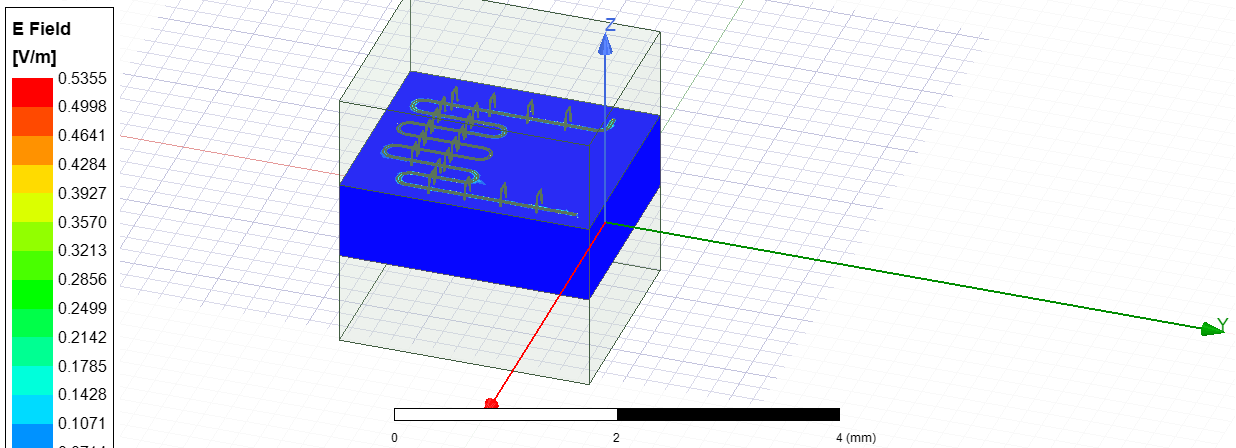

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [54]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [55]:
hfss.epr_get_frequencies()

Design "cavity1" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.035158,inf


In [56]:
hfss.activate_eigenmode_design("cavity2")

08:51PM 22s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
08:51PM 22s WARNING [activate_ansys_design]: The design_name=cavity2 was not in active project.  Designs in active project are: 
['cavity1'].  A new design will be added to the project.  
INFO 08:51PM [connect_design]: 	Opened active design
	Design:    cavity2 [Solution type: Eigenmode]
WARNING 08:51PM [connect_setup]: 	No design setup detected.
WARNING 08:51PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:51PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [88]:
hfss.render_design(['cavity2'], [('cavity2', 'end'), ('cavity2', 'start')])

In [89]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:30PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:34PM 59s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


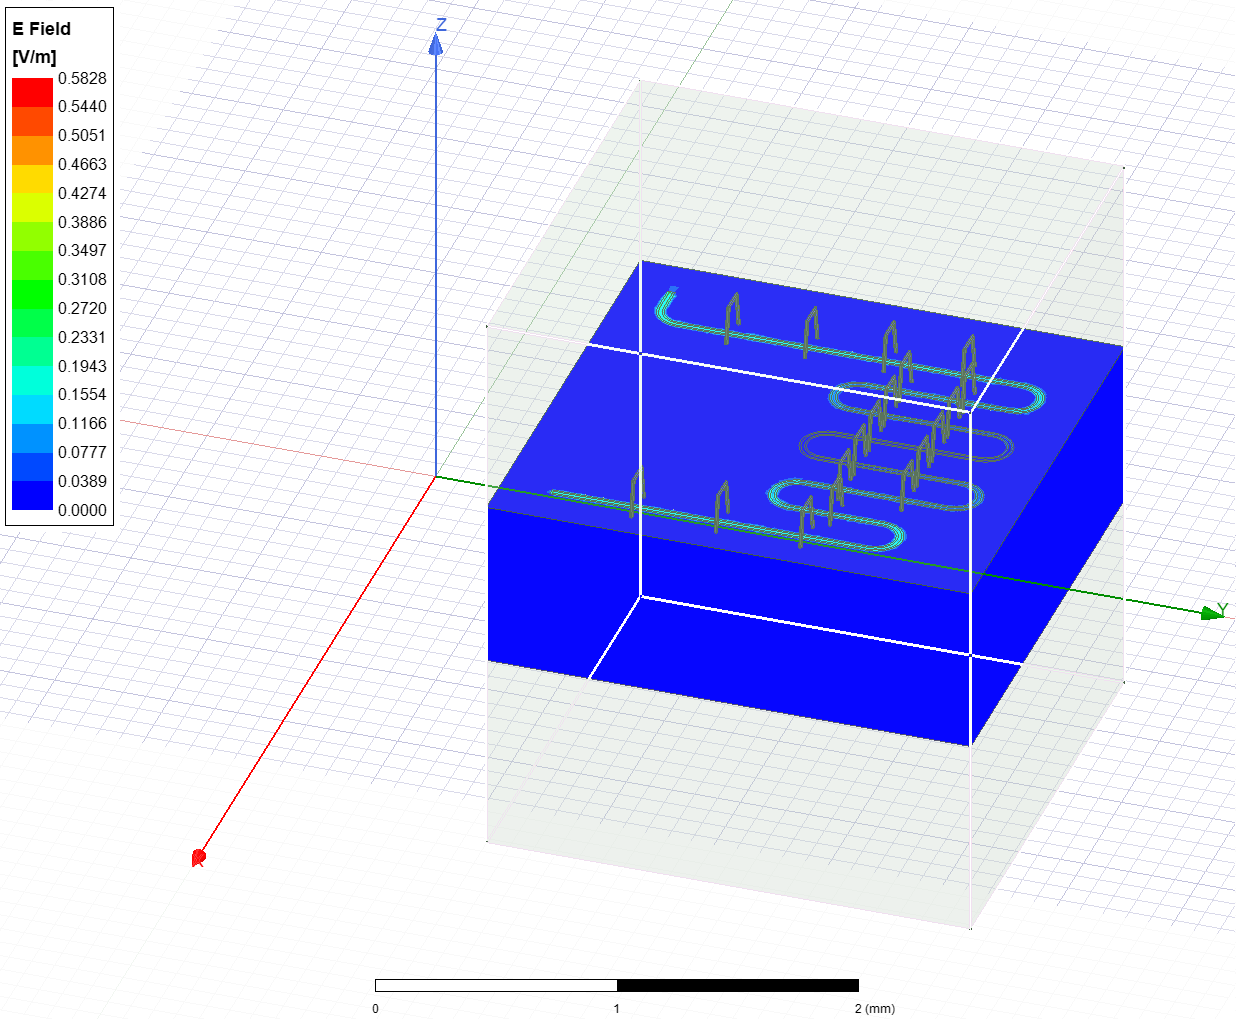

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [90]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [91]:
hfss.epr_get_frequencies()

Design "cavity2" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,6.615862,inf


In [92]:
hfss.activate_eigenmode_design("cavity4")

02:35PM 04s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:35PM 04s WARNING [activate_ansys_design]: The design_name=cavity4 was not in active project.  Designs in active project are: 
['Design_q3d', 'Sweep_DrivenModal_hfss', 'cavity2', 'cavity1'].  A new design will be added to the project.  
INFO 02:35PM [connect_design]: 	Opened active design
	Design:    cavity4 [Solution type: Eigenmode]
WARNING 02:35PM [connect_setup]: 	No design setup detected.
WARNING 02:35PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:35PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [93]:
hfss.render_design(['cavity4'], [('cavity4', 'end'), ('cavity4', 'start')])

In [94]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:35PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:37PM 34s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


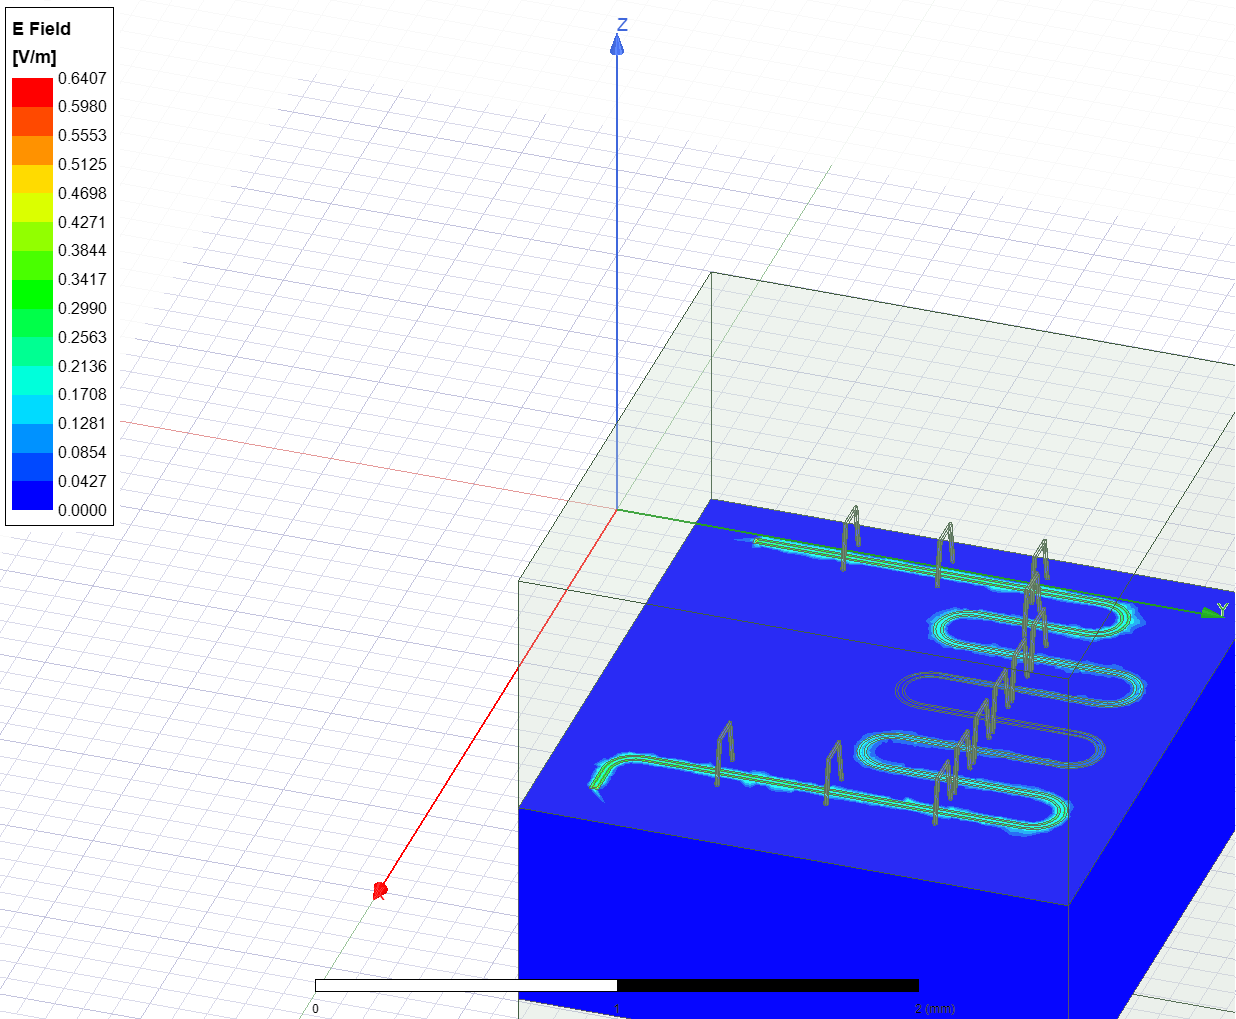

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [95]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [96]:
hfss.epr_get_frequencies()

Design "cavity4" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.220044,inf


In [97]:
hfss.activate_eigenmode_design("cavity5")

02:37PM 37s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:37PM 37s WARNING [activate_ansys_design]: The design_name=cavity5 was not in active project.  Designs in active project are: 
['Design_q3d', 'Sweep_DrivenModal_hfss', 'cavity2', 'cavity1', 'cavity4'].  A new design will be added to the project.  
INFO 02:37PM [connect_design]: 	Opened active design
	Design:    cavity5 [Solution type: Eigenmode]
WARNING 02:37PM [connect_setup]: 	No design setup detected.
WARNING 02:37PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [98]:
hfss.render_design(['cavity5'], [('cavity5', 'end'), ('cavity5', 'start')])

In [99]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10.0 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:37PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


02:40PM 10s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


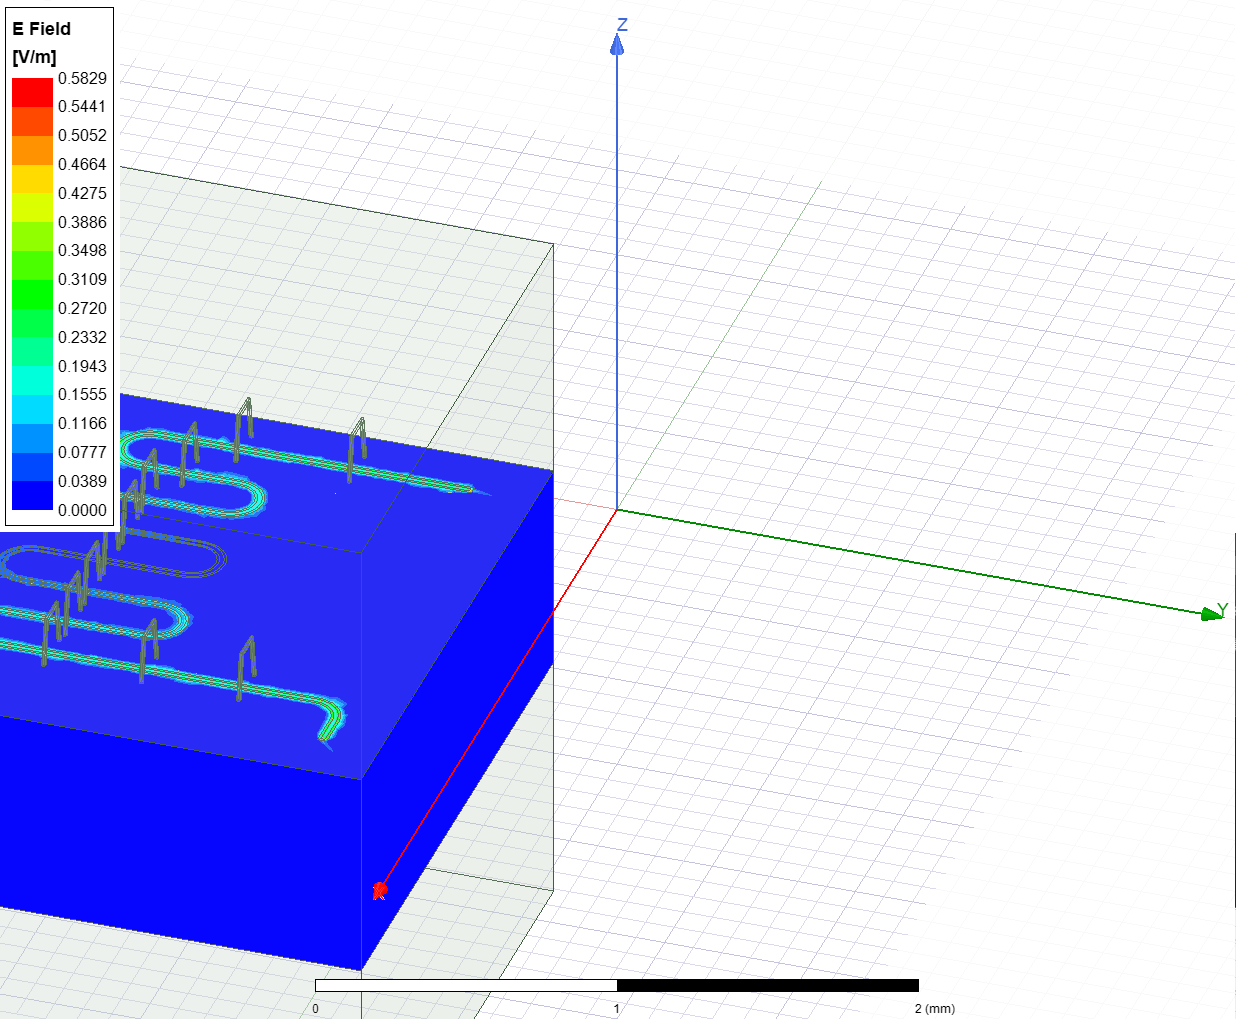

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [100]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [101]:
hfss.epr_get_frequencies()

Design "cavity5" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.822478,inf


In [102]:
QAnsysRenderer.get_template_options(design)

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [58]:
QAnsysRenderer.default_setup

{'drivenmodal': {'name': 'Setup',
  'freq_ghz': '5.0',
  'max_delta_s': '0.1',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '1'},
 'eigenmode': {'name': 'Setup',
  'min_freq_ghz': '1',
  'n_modes': '1',
  'max_delta_f': '0.5',
  'max_passes': '10',
  'min_passes': '1',
  'min_converged': '1',
  'pct_refinement': '30',
  'basis_order': '-1'},
 'q3d': {'name': 'Setup',
  'freq_ghz': '5.0',
  'save_fields': 'False',
  'enabled': 'True',
  'max_passes': '15',
  'min_passes': '2',
  'min_converged_passes': '2',
  'percent_error': '0.5',
  'percent_refinement': '30',
  'auto_increase_solution_order': 'True',
  'solution_order': 'High',
  'solver_type': 'Iterative'},
 'port_inductor_gap': '10um'}

In [38]:
# Run this cell only if you are done with ANSYS
hfss.disconnect_ansys()

In [103]:
hfss.clean_active_design()

In [57]:
hfss.activate_eigenmode_design("Q1_Res1")

08:51PM 58s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
08:51PM 58s WARNING [activate_ansys_design]: The design_name=Q1_Res1 was not in active project.  Designs in active project are: 
['cavity2', 'cavity1'].  A new design will be added to the project.  
INFO 08:52PM [connect_design]: 	Opened active design
	Design:    Q1_Res1 [Solution type: Eigenmode]
WARNING 08:52PM [connect_setup]: 	No design setup detected.
WARNING 08:52PM [connect_setup]: 	Creating eigenmode default setup.
INFO 08:52PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [58]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [59]:
 hfss.render_design(['Q1', 'cavity1', 'otg1s'],[('cavity1', 'end')])

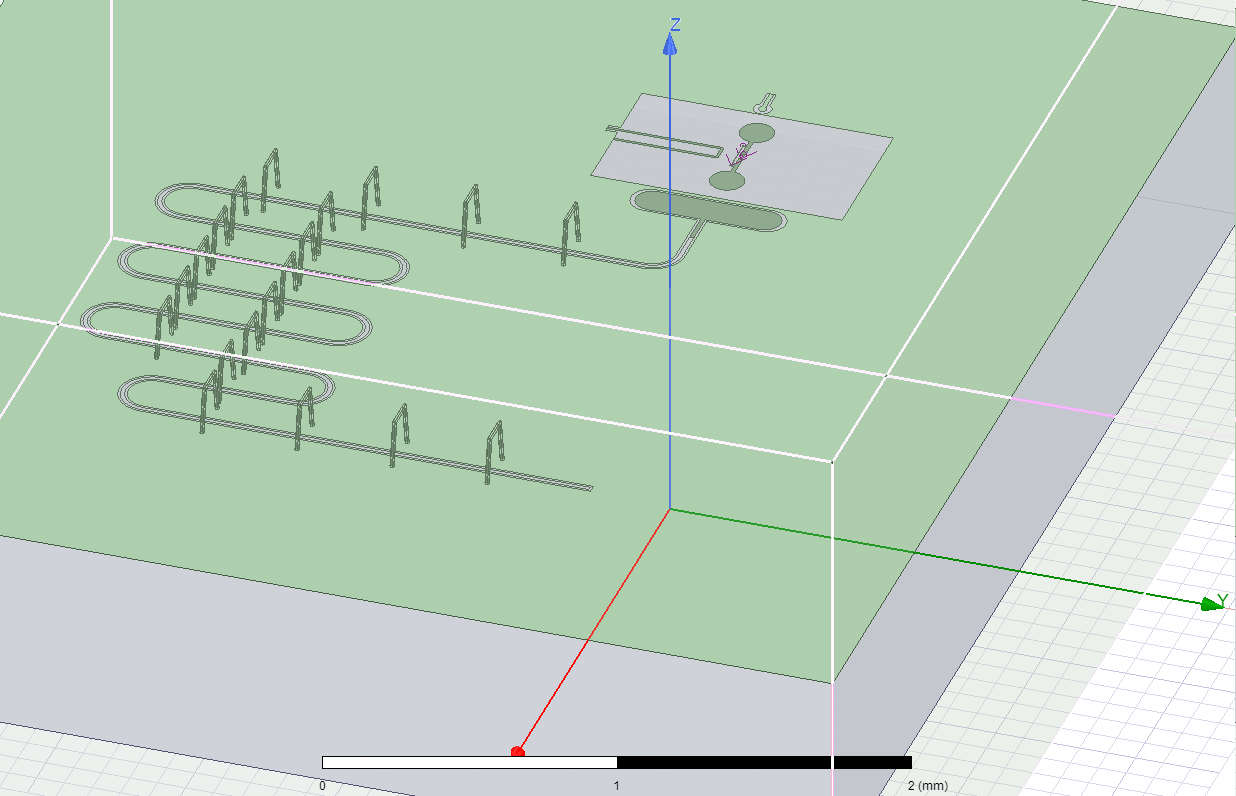

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [60]:
hfss.save_screenshot()

In [61]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 08:52PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


09:15PM 05s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



09:15PM 24s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


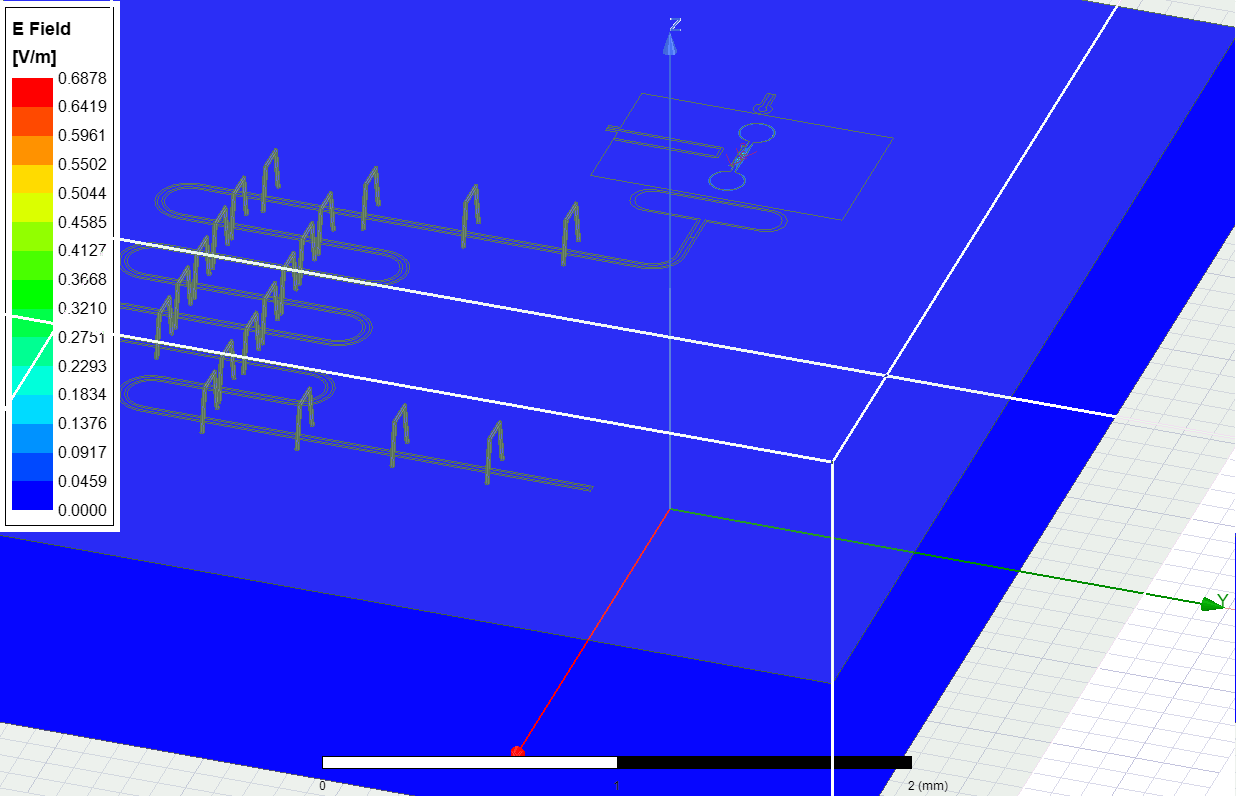

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [67]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [73]:
hfss.plot_ansys_delete(['Mag_E1'])

09:16PM 30s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [74]:
hfss.set_mode(2, "Setup")

INFO 09:16PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


09:16PM 40s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


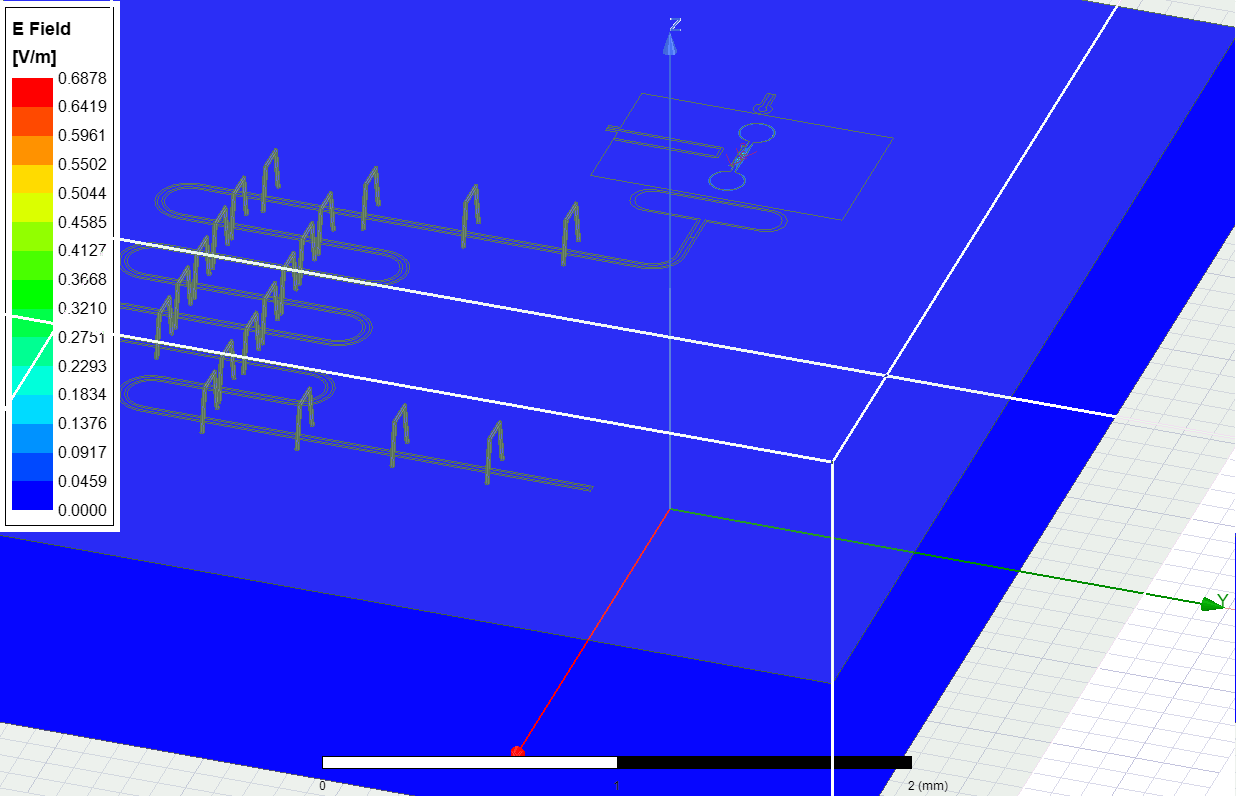

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [75]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [76]:
hfss.plot_ansys_delete(['Mag_E1'])

09:16PM 54s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [77]:
hfss.epr_get_frequencies()

Design "Q1_Res1" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.484434             inf
          1        6.407318             inf

In [116]:
hfss.activate_eigenmode_design("Q2_Res2")

04:04PM 18s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:04PM 18s WARNING [activate_ansys_design]: The design_name=Q2_Res2 was not in active project.  Designs in active project are: 
['Design_q3d', 'Sweep_DrivenModal_hfss', 'cavity5', 'Q1_Res1', 'cavity2', 'cavity1', 'cavity4'].  A new design will be added to the project.  
INFO 04:04PM [connect_design]: 	Opened active design
	Design:    Q2_Res2 [Solution type: Eigenmode]
WARNING 04:04PM [connect_setup]: 	No design setup detected.
WARNING 04:04PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:04PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [117]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [118]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,153,inductor,"LINESTRING (-2.13500 -0.49300, -2.26500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
1,153,rect_jj,"LINESTRING (-2.21500 -0.47500, -2.18500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
2,154,inductor,"LINESTRING (-2.13500 0.49300, -2.26500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
3,154,rect_jj,"LINESTRING (-2.18500 0.47500, -2.21500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
4,155,inductor,"LINESTRING (2.26500 0.49300, 2.13500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
5,155,rect_jj,"LINESTRING (2.21500 0.47500, 2.18500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
6,156,inductor,"LINESTRING (2.26500 -0.49300, 2.13500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
7,156,rect_jj,"LINESTRING (2.18500 -0.47500, 2.21500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
8,157,rect_jj,"LINESTRING (-2.79000 0.00000, -2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_
9,158,rect_jj,"LINESTRING (2.79000 0.00000, 2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_


In [119]:
hfss.render_design(['Q2', 'cavity2', 'otg2s'],[('cavity2', 'end')])

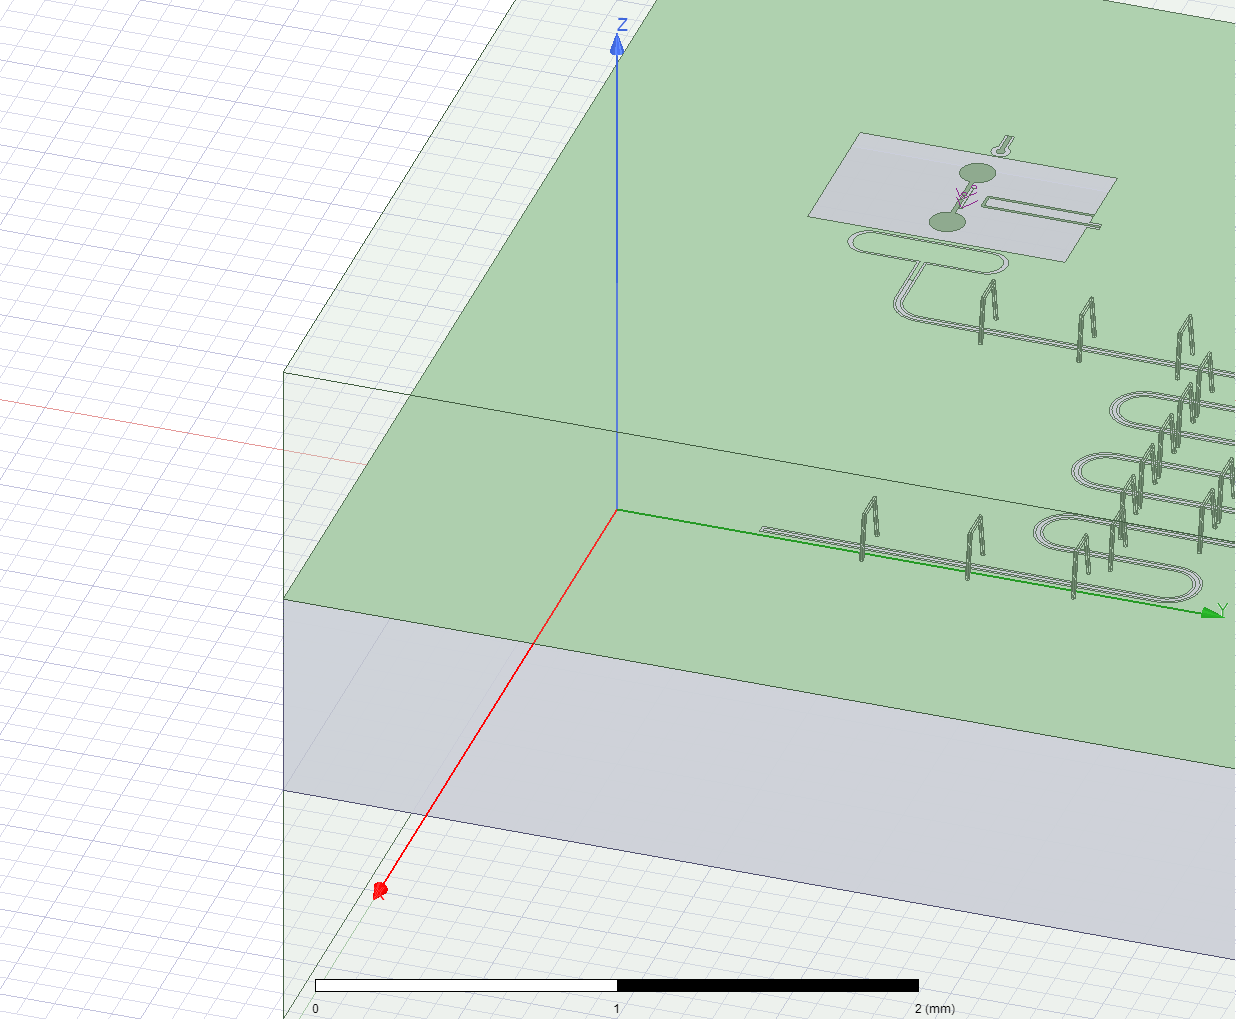

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [120]:
hfss.save_screenshot()

In [121]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 04:04PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:20PM 20s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


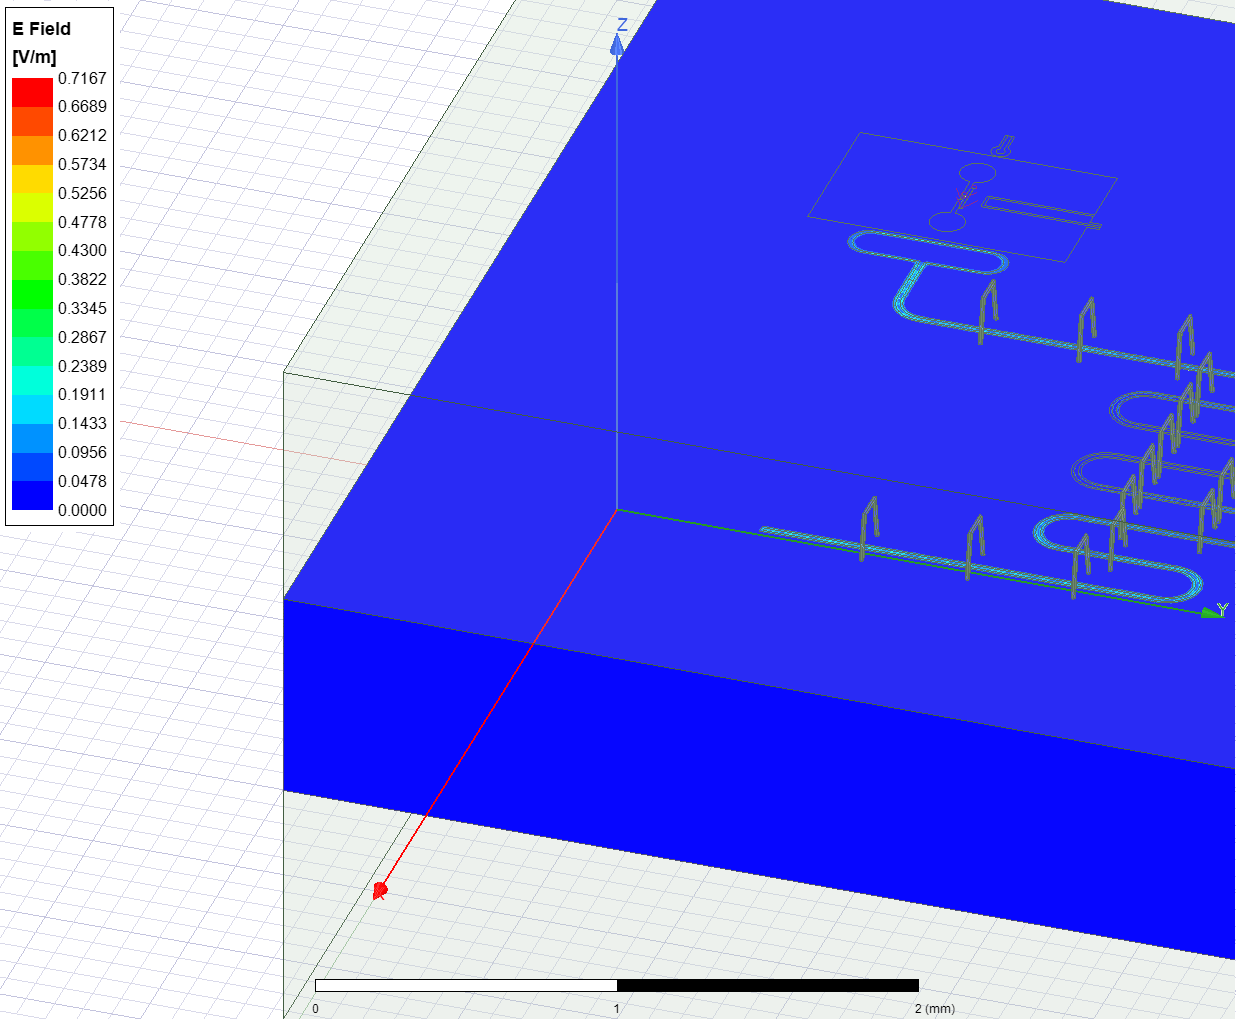

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [122]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [123]:
hfss.epr_get_frequencies()

Design "Q2_Res2" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.955879             inf
          1        6.381932             inf

In [77]:
hfss.connect_ansys()

INFO 06:15PM [connect_project]: Connecting to Ansys Desktop API...
INFO 06:15PM [load_ansys_project]: 	Opened Ansys App
INFO 06:15PM [load_ansys_project]: 	Opened Ansys Desktop v2021.2.0
INFO 06:15PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/ana/
	Project:   Project57
INFO 06:15PM [connect_design]: 	Opened active design
	Design:    Q2_Res2 [Solution type: Eigenmode]
INFO 06:15PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 06:15PM [connect]: 	Connected to project "Project57" and design "Q2_Res2" 😀 



In [124]:
hfss.activate_eigenmode_design("Q4_Res4")

04:20PM 32s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:20PM 32s WARNING [activate_ansys_design]: The design_name=Q4_Res4 was not in active project.  Designs in active project are: 
['Design_q3d', 'Q2_Res2', 'Sweep_DrivenModal_hfss', 'cavity5', 'Q1_Res1', 'cavity2', 'cavity1', 'cavity4'].  A new design will be added to the project.  
INFO 04:20PM [connect_design]: 	Opened active design
	Design:    Q4_Res4 [Solution type: Eigenmode]
WARNING 04:20PM [connect_setup]: 	No design setup detected.
WARNING 04:20PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:20PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [125]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [126]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,153,inductor,"LINESTRING (-2.13500 -0.49300, -2.26500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
1,153,rect_jj,"LINESTRING (-2.21500 -0.47500, -2.18500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
2,154,inductor,"LINESTRING (-2.13500 0.49300, -2.26500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
3,154,rect_jj,"LINESTRING (-2.18500 0.47500, -2.21500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
4,155,inductor,"LINESTRING (2.26500 0.49300, 2.13500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
5,155,rect_jj,"LINESTRING (2.21500 0.47500, 2.18500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
6,156,inductor,"LINESTRING (2.26500 -0.49300, 2.13500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
7,156,rect_jj,"LINESTRING (2.18500 -0.47500, 2.21500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
8,157,rect_jj,"LINESTRING (-2.79000 0.00000, -2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_
9,158,rect_jj,"LINESTRING (2.79000 0.00000, 2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_


In [127]:
hfss.render_design(['Q4', 'cavity4', 'otg4s'],[('cavity4', 'end')])

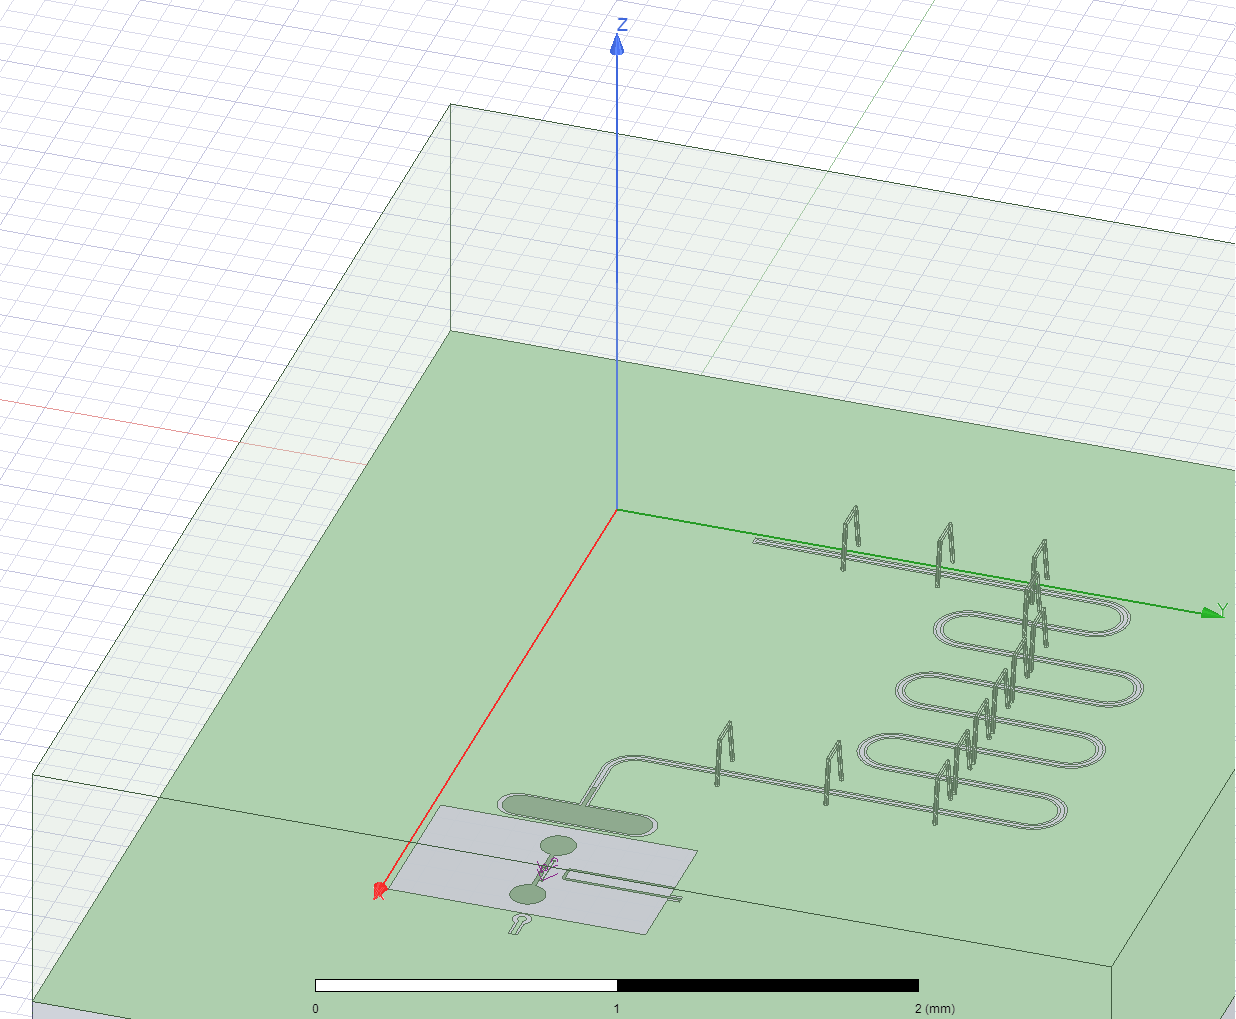

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [128]:
hfss.save_screenshot()

In [129]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()


Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1



INFO 04:20PM [analyze]: Analyzing setup Setup


This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


04:32PM 33s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


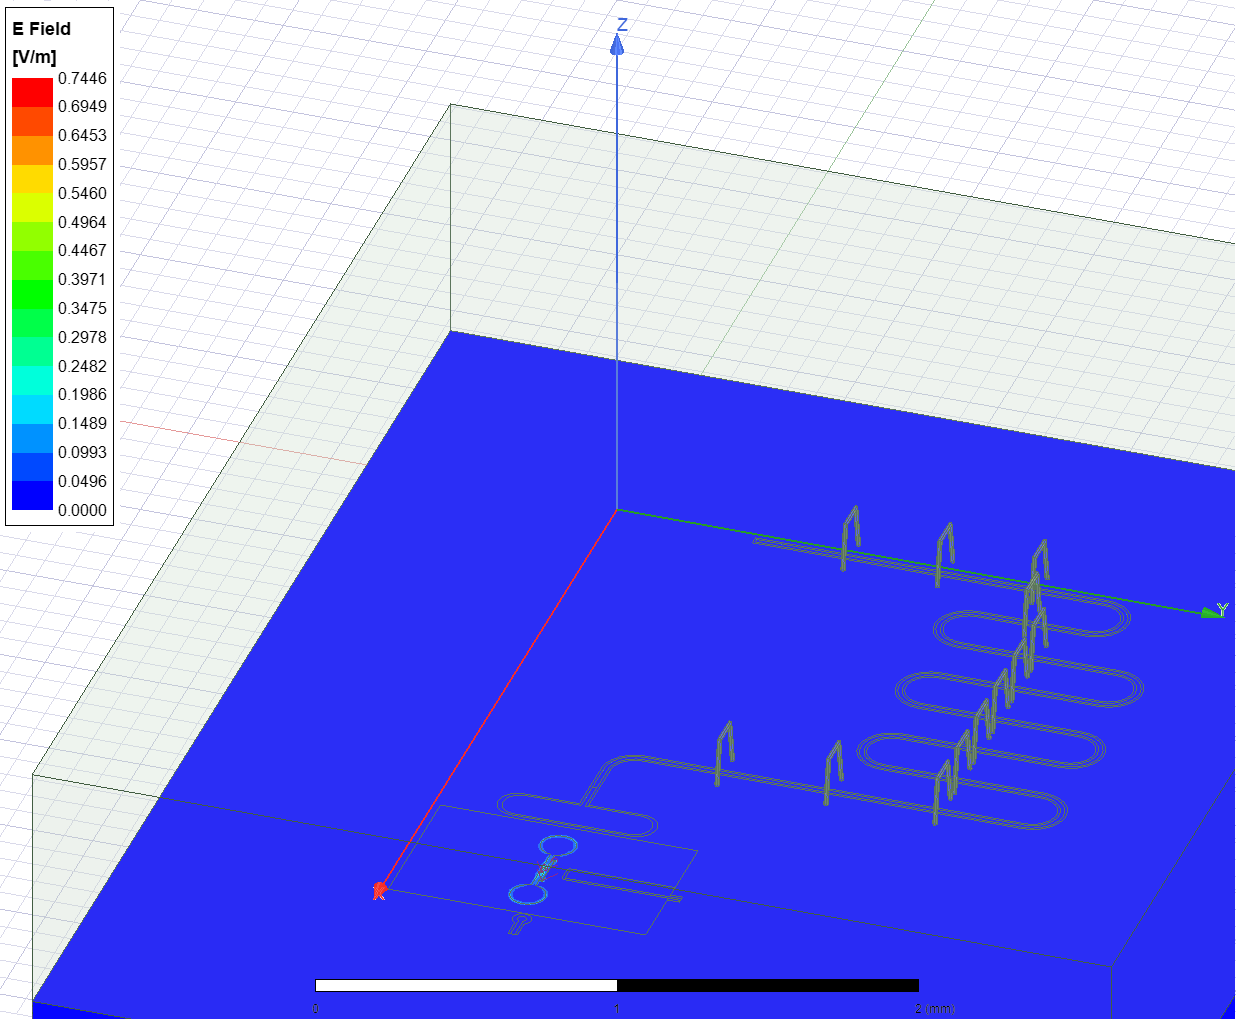

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [130]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [131]:
hfss.epr_get_frequencies()

Design "Q4_Res4" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.336635             inf
          1        6.472919             inf

In [143]:
#hfss.disconnect_ansys()

In [132]:
hfss.activate_eigenmode_design("Q5_Res5")

04:32PM 40s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
04:32PM 40s WARNING [activate_ansys_design]: The design_name=Q5_Res5 was not in active project.  Designs in active project are: 
['Design_q3d', 'Q2_Res2', 'Sweep_DrivenModal_hfss', 'cavity5', 'Q1_Res1', 'cavity2', 'Q4_Res4', 'cavity1', 'cavity4'].  A new design will be added to the project.  
INFO 04:32PM [connect_design]: 	Opened active design
	Design:    Q5_Res5 [Solution type: Eigenmode]
WARNING 04:32PM [connect_setup]: 	No design setup detected.
WARNING 04:32PM [connect_setup]: 	Creating eigenmode default setup.
INFO 04:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [133]:
hfss.options['x_buffer_width_mm'] = 0.9
hfss.options['y_buffer_width_mm'] = 0.9
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [134]:
design.qgeometry.tables['junction']

,component,name,geometry,layer,subtract,helper,chip,width,hfss_inductance,hfss_capacitance,hfss_resistance,hfss_mesh_kw_jj,q3d_inductance,q3d_capacitance,q3d_resistance,q3d_mesh_kw_jj,gds_cell_name
0,153,inductor,"LINESTRING (-2.13500 -0.49300, -2.26500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
1,153,rect_jj,"LINESTRING (-2.21500 -0.47500, -2.18500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
2,154,inductor,"LINESTRING (-2.13500 0.49300, -2.26500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
3,154,rect_jj,"LINESTRING (-2.18500 0.47500, -2.21500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
4,155,inductor,"LINESTRING (2.26500 0.49300, 2.13500 0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v1_
5,155,rect_jj,"LINESTRING (2.21500 0.47500, 2.18500 0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
6,156,inductor,"LINESTRING (2.26500 -0.49300, 2.13500 -0.49300)",1,False,False,main,0.001,200.0nH,0,0,0.000007,10nH,0,0,0.000007,jj_array_v2_
7,156,rect_jj,"LINESTRING (2.18500 -0.47500, 2.21500 -0.47500)",1,False,False,main,0.010,34.38nH,0,0,0.000007,10nH,0,0,0.000007,junction_
8,157,rect_jj,"LINESTRING (-2.79000 0.00000, -2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_
9,158,rect_jj,"LINESTRING (2.79000 0.00000, 2.76000 0.00000)",1,False,False,main,0.010,10nH,0,0,0.000007,10nH,0,0,0.000007,junction_sq_


In [135]:
hfss.render_design(['Q5', 'cavity5', 'otg5s'],[('cavity5', 'end')])

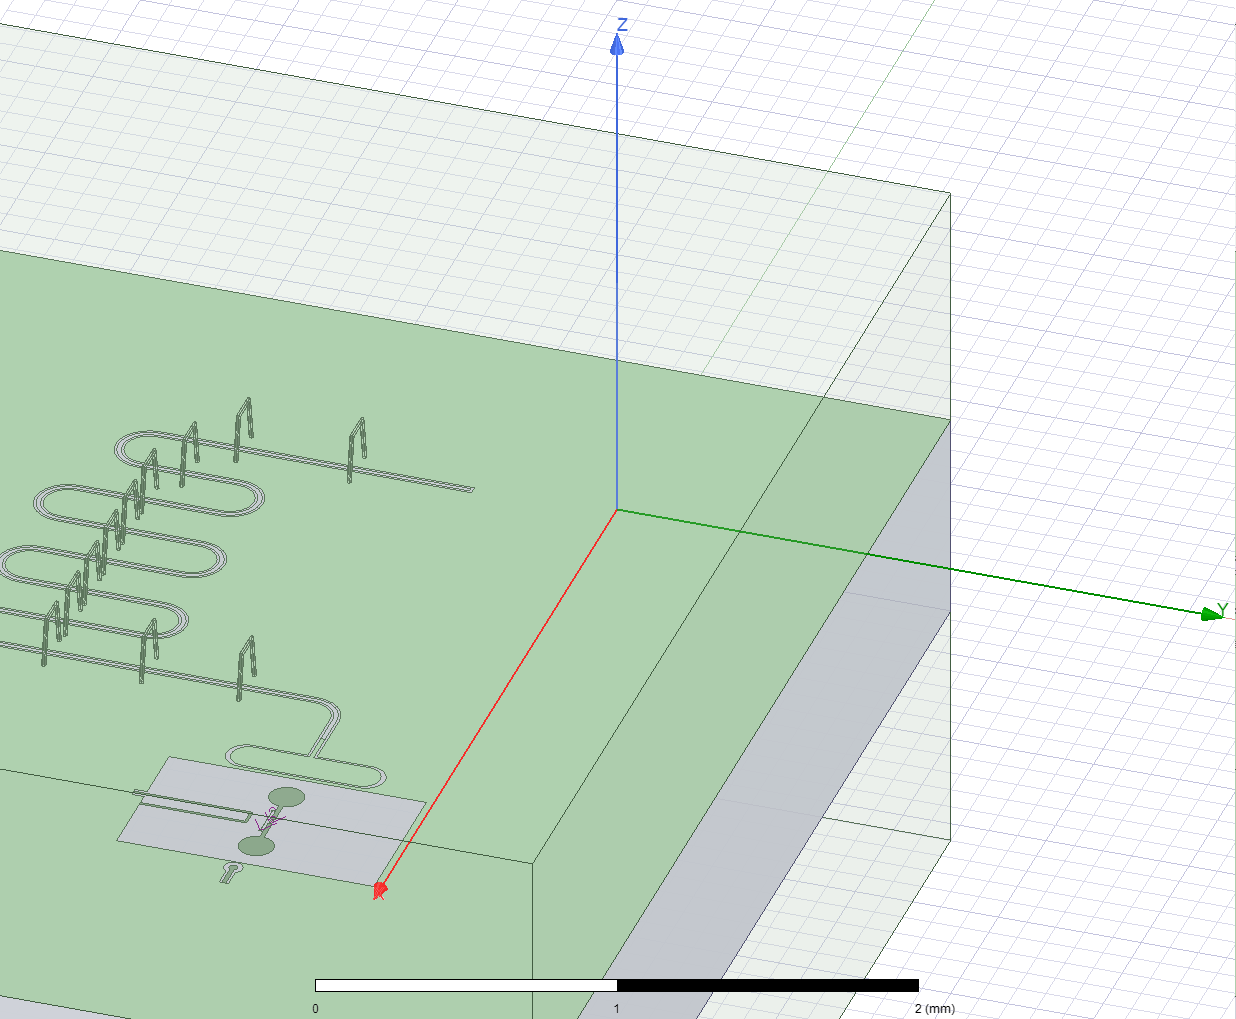

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [136]:
hfss.save_screenshot()

In [137]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 04:33PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


05:09PM 11s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


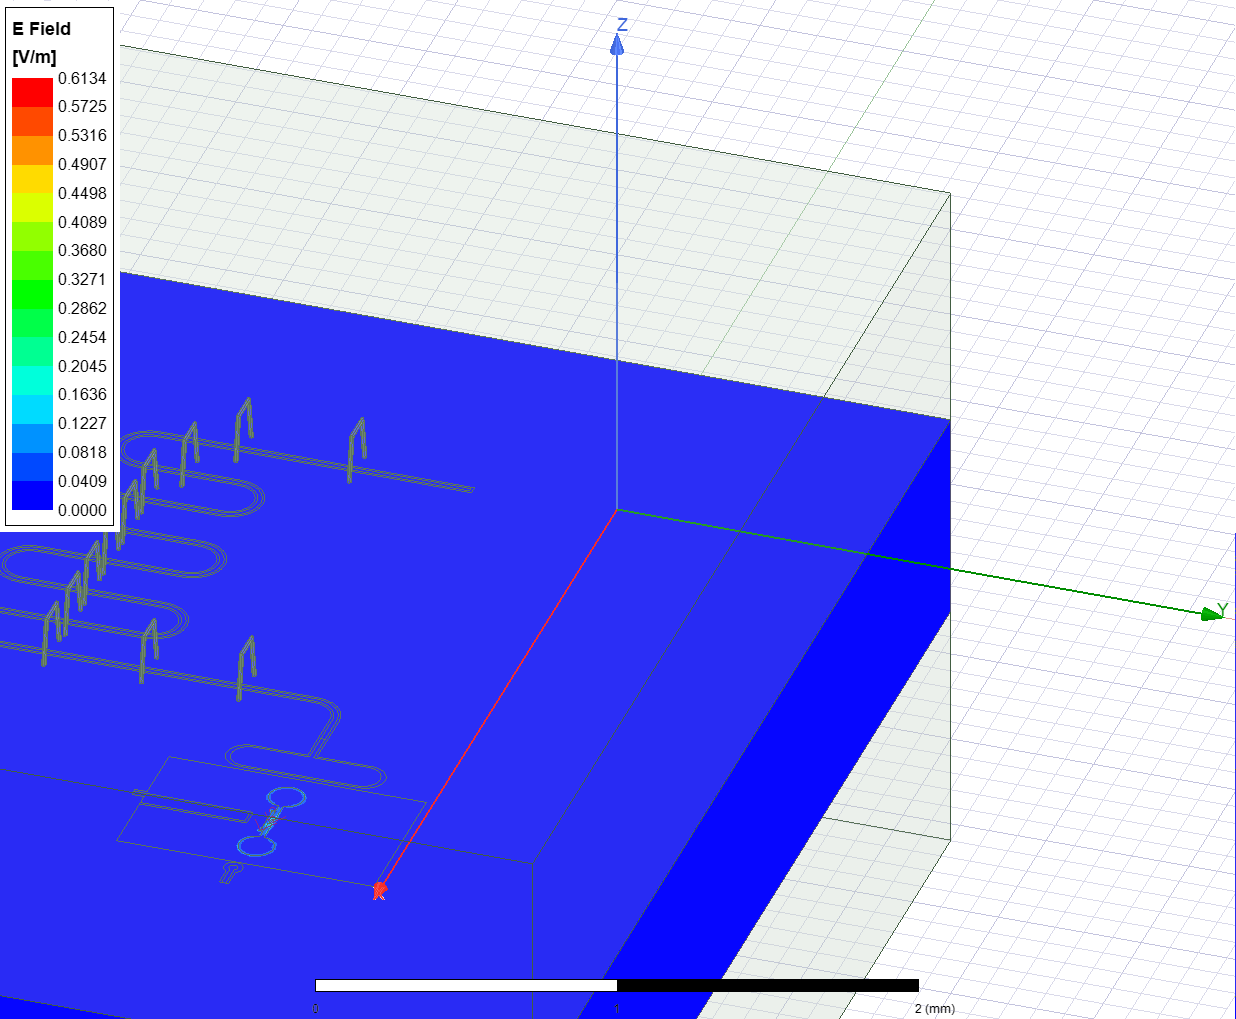

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [138]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [139]:
hfss.epr_get_frequencies()

Design "Q5_Res5" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        6.336163             inf
          1        6.923041             inf

In [140]:
hfss.plot_ansys_delete(['Mag_E1'])

05:10PM 30s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [141]:
hfss.set_mode(2, "Setup")

INFO 05:10PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


05:10PM 33s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


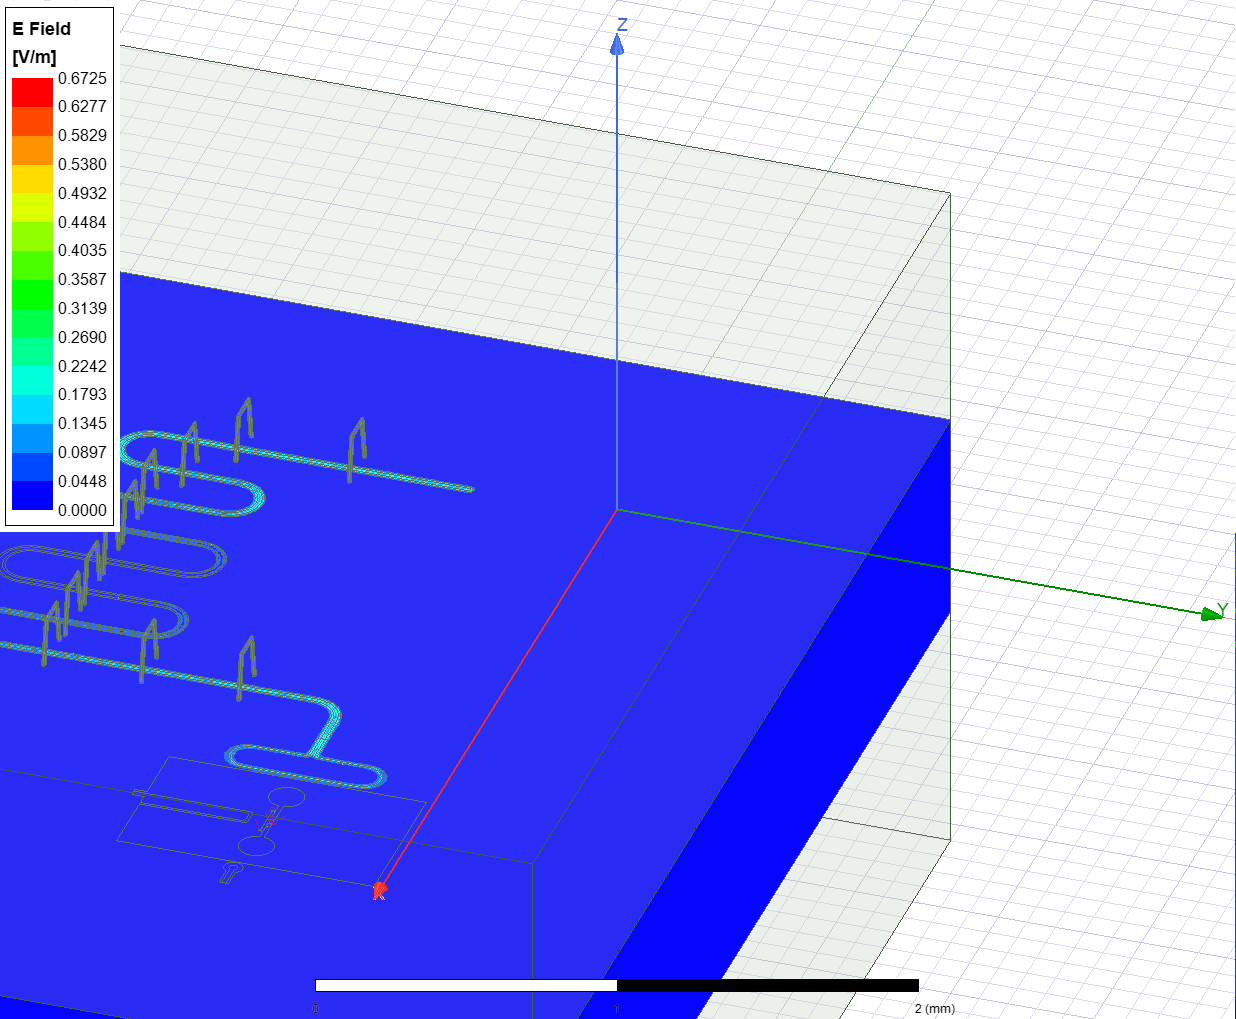

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/figen-qiskit-metal/Shitty-Files/GDS-DR/ansys.png')

In [142]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [ ]:
hfss.save_screenshot()

In [ ]:
hfss.plot_ansys_delete(['Mag_E1'])

In [ ]:
hfss.activate_eigenmode_design("Q1_charge1")

In [ ]:
hfss.render_design(['Q1', 'XY_Gate1'],[('XY_Gate1', 'start')])

In [ ]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '34.38 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [ ]:
hfss.epr_get_frequencies()

In [ ]:
hfss.plot_ansys_delete(['Mag_E1'])

In [ ]:
hfss.set_mode(2, "Setup")

In [ ]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [ ]:
hfss.epr_get_frequencies()

In [ ]:
eig_qb = EPRanalysis(design,"hfss")

In [ ]:
eig_qb.sim.setup_update(n_modes = 2,
                        max_delta_f = 0.1,
                        min_freq_ghz = 1,
                        max_passes = 12)
eig_qb.sim.setup.vars.Lj = '34.3nH'
eig_qb.sim.setup.vars.Cj = '0.0nH'
eig_qb.sim.setup.vars.Ls = q1.options.l_inductance

eig_qb.sim.setup

In [ ]:
eig_qb.sim.run(name="FluxoniumEPR", components=['Q1', 'XY_Gate1'], open_terminations=[], box_plus_buffer = False)

In [ ]:
eig_qb.sim.convergence_f

In [ ]:
# Add the geometry of the rectangle  and line of the inductor to the list of junctions
eig_qb.setup.junctions.jj.rect = 'JJ_rect_Lj_Q1_rect_jj'
eig_qb.setup.junctions.jj.line = 'JJ_Lj_Q1_rect_jj_'

eig_qb.add_junction(name_junction ='inductor')
eig_qb.setup.junctions.inductor.Lj_variable = 'Ls'
eig_qb.setup.junctions.inductor.rect = 'JJ_rect_Lj_Q1_inductor'
eig_qb.setup.junctions.inductor.line = 'JJ_Lj_Q1_inductor_'
# eig_qb.setup.junctions.inductor.is_junction = False

# Set up th EPR analysis parameters
eig_qb.setup.fock_trunc = 15
eig_qb.setup.cos_trunc = 6
eig_qb.setup.flux = 0.0

eig_qb.setup.basis = 'HO'

# eig_qb.setup.sweep_variable = 'flux'   #--- This would be nice to implement to get a sweep over flux bias 
eig_qb.setup

In [ ]:
# eig_qb.run_epr()
#### equivalent individual calls
s = eig_qb.setup
eig_qb.epr_start()
eig_qb.get_stored_energy()
eig_qb.run_analysis()

In [ ]:
eig_qb.spectrum_analysis(s.cos_trunc, s.fock_trunc, basis=s.basis, flux=s.flux, junctions=[0])
eig_qb.report_hamiltonian(s.sweep_variable)

# Creating the GDS file

In [24]:
fluxonium_gds = design.renderers.gds
fluxonium_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': True,
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': 'JJ_SquidJJ_and_twoversionarray2.gds',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [32]:
fluxonium_gds.options['path_filename'] = 'JJ_SquidJJ_and_twoversionarray2.gds'

In [33]:
fluxonium_gds.options['fabricate'] = True

In [34]:
fluxonium_gds.export_to_gds('FXTFX23-W4-01-V1-JJs.gds')

08:43PM 57s WARNING [_give_rotation_center_twopads]: In junction table, component=Q1 with name=inductor has width=0.001 smaller than cell dimension=0.017195000000000002.
08:43PM 57s WARNING [_give_rotation_center_twopads]: In junction table, component=Q2 with name=inductor has width=0.001 smaller than cell dimension=0.017.
08:43PM 57s WARNING [_give_rotation_center_twopads]: In junction table, component=Q4 with name=inductor has width=0.001 smaller than cell dimension=0.017.
08:43PM 57s WARNING [_give_rotation_center_twopads]: In junction table, component=Q5 with name=inductor has width=0.001 smaller than cell dimension=0.017195000000000002.
08:43PM 57s WARNING [_import_junctions_to_one_cell]: From the "junction" table, the cell named "gds_cell_inductor"",  is not in file: JJ_SquidJJ_and_twoversionarray2.gds. The cell was not used.
08:43PM 57s WARNING [_import_junctions_to_one_cell]: From the "junction" table, the cell named "gds_cell_inductor"",  is not in file: JJ_SquidJJ_and_twovers

1